# Glacier area - streamflow scaling in Alberta

### Goal

Investigate how the loss of glaciers will impact August streamflow at downstream locations.

### Overview

We will use two empirical models.  The first estimates mean August streamflow in glacier-fed rivers based on the area fraction of glaciers in the watershed.  The second estimates mean August streamflow in non-glacier-fed rivers based on local conditions.  The difference between these two model predictions is an estimate for how much, and in what ways, a glacier-fed river may change under a total loss of glaciers. 

### Introduction

The following figures were generated by characterizing August streamflow data [$m^3 s^{-1}$] throughout Alberta:

<table><tr><td><img src='std_vs_mean.png' width=350 ></td><td><img src='streamflow_clusters.png' width=400></td></tr></table>

In the above figure, $PC_1$ correlates with mean August flow, and $\sigma_{PC1}$ indicates the year-to-year variability of $PC_1$.  Cluster 3 is made up primarily of glacier-fed rivers which are sourced in the glaciated region of the Rocky Mountains.  In a), there are generally two regimes present:

- Clusters 1, 2, 4, 5, and 6, where an increase in mean is accompanied by an increase in variability (i.e. when August flow is high on average, it is not consistently high each year; when August flow is low on average, it is low each year)
- Cluster 3, where an increase in mean can be achieved without the cost of an increase in variability (i.e. when August flow is high on average, it is consistently high each year)

Additionally, we find that there is a non-linear relationship between the percentage glacierization $G$ (here defined as the glacier area divided by the basin area, expressed as a value between 0 and 1), and the mean $PC_1$ value.  This relationship is most pronounced when $G>0.01$ (or 1% glacierization).  This means that for sufficiently glaciated rivers, to estimate the mean $PC_1$, all we need to know is $G$, which can be calculated at any point along a river.

<img src='glacier_influence.png' width=350 >

For non-glacier-fed rivers, we find that both $PC_1$ and $\sigma_{PC1}$ can be estimated by metrics derived from local climate and conditions:

$$
\overline {PC_1} = -0.34 - 0.60\times T_{year} + 0.96\times P_{JJA} + 0.87\times T_{JJA} + 0.44\times E_{JJA} + 0.41\times log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)
$$

$$
\sigma_{PC_1} = -2.49 + 0.52\times P_{JJA} + 0.26\times E_{JJA} - 0.68\times h + 0.42\times log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)
$$

Where:

- $T_{year}$ is the yearly average temperature [$^{\circ}C$]
- $T_{JJA}$ is the June-July-August average temperature [$^{\circ}C$]
- $P_{JJA}$ is the June-July-August total precipitation [$mm$]
- $E_{JJA}$ is the June-July-August average evaporation [$mm$]
- $Q_{min}$ is the minimum seasonal streamflow [$m^3 s^{-1}$]
- $Q_{max}$ is the maximum seasonal streamflow [$m^3 s^{-1}$]
- $h$ is the stream gauge elevation [$m$]

All predictor variables are noramlized to have zero mean and unity variance (dimensionless), but their original dimensions are shown above.

### Key takeaways:

- August streamflow in glacier-fed rivers can be estimated by $G$.

- August streamflow in non-glacier-fed rivers can be estimated by $T_{year}$, $T_{JJA}$, $P_{JJA}$, $E_{JJA}$, $Q_{min}$, $Q_{max}$, and $h$.

### Question:

How will August streamflow distributions change in time in a basin which transitions from sufficiently glaciated to not glaciated?

### Discussion:

First, let's visualize how glacierization will change in time.

**Assume:** 

- Glacier area is decreasing linearly with time, until all glacier area is gone.  

**Relevant parameters:**

- $t_g$: Time for glaciers to entirely melt; i.e. $G(t = t_g) = 0$
- $G_0$: Initial glacierization area, as a fraction of basin area (between 0 and 1) 

**Equation:**

$
G(t) = \left\{
\begin{array}{ll}
    G_0(1 - \frac{t}{t_g}) & , t < t_g \\
    0 & , t\ge t_g \\
\end{array}
\right.
$



In [1]:
#load required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from IPython.display import HTML, display
import ipywidgets

In [2]:
#define functions we'll use
def make_gaussian(mu, sigma):
    
    # This function generates a gaussian distribution from a mean (mu) and standard deviation (sigma)
    # mu = mean
    # sigma = std deviation
    
    x = np.linspace(mu-4*sigma,mu+4*sigma,100)
    gauss = [(1 / sigma / np.sqrt(2*np.pi)) * np.exp(-0.5 * ((xx - mu)/sigma)**2) for xx in x]
    
    return gauss, x

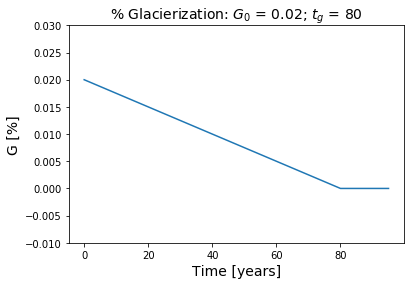

In [3]:
#define constants, G(t)
t_g = 80 #time in years for total loss of glaciers
t_f = 1.2 * t_g #final time in years
dt = 1 #time step
Ng = int(t_g / dt) #number of time steps for total loss of glaciers
Nf = int(t_f / dt) #number of total time steps
t = np.linspace(0, t_f-1, Nf) #time (years) 

G_0 = 0.02 #initial glacierization
G = G_0 * (1 - t/t_g) #G(t)
G[G<0] = 0 #set negative glacierization to 0 (e.g. G(t>t_g) = 0)

#visualize
fs = 14 #fontsize to use in figures
fig, ax = plt.subplots()
ax.plot(t, G)
ax.set_xlabel('Time [years]', fontsize = fs)
ax.set_ylabel('G [%]', fontsize = fs)
ax.set_title('% Glacierization: $G_0$ = ' + str(G_0) + '; $t_g$ = ' + str(t_g), fontsize = fs)
ax.set_ylim((np.min(G) - 0.01, np.max(G)+0.01))

plt.show()

Let's simplify Figure a) to show the two regimes and discuss what we expect to happen as $G(t) \rightarrow 0$.

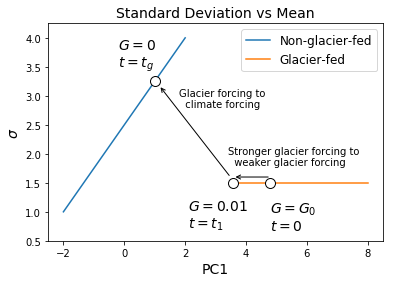

In [4]:
t_1 = t_g*(1 - 0.01/G_0) #time (years) when 1% glacierization threshold is reached (i.e. G(t_1) = 0.01)
N1 = int(t_1 / dt) #number of timesteps to 1% glacierization

PC1_0 = 11.6 + 1.74*np.log(G_0) #initial PC1 (see: Equation 4 in reference)
PC1_g = 11.6 + 1.74*np.log(0.01) #PC1 at 1% glacierization
PC1_f = 1 #final PC1

sigma_0 = 1.5 #initial sigma
sigma_g = sigma_0 #sigma at 1% glacierization
sigma_f = 2.5 + 0.75*PC1_f #final sigma (estimated from relationship between sigma and PC1 in Figure a)

PC1_climate = np.linspace(-2,2,100) #climate driven PC1 (estimated from Figure a))
sigma_climate = 2.5 + 0.75*PC1_climate #climate driven sigma

PC1_glaciers = np.linspace(PC1_g,8,100) #glacier-driven PC1
sigma_glaciers = 1.5 * np.ones_like(PC1_glaciers) #glacier-driven sigma

#visualize
fig, ax = plt.subplots()

ax.plot(PC1_climate, sigma_climate, label = 'Non-glacier-fed')
ax.plot(PC1_glaciers, sigma_glaciers, label = 'Glacier-fed')

ax.scatter(PC1_0, sigma_0, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = PC1_0+0., y = sigma_0 - 0.8, s = '$G=G_0$ \n$t=0$', fontsize = fs)

ax.scatter(PC1_g, sigma_g, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = PC1_g-1.5, y = sigma_g - 0.8, s = '$G=0.01$ \n$t=t_1$', fontsize = fs)

ax.scatter(PC1_f, sigma_f, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = PC1_f - 1.2, y = sigma_f + 0.2, s = '$G=0$ \n$t=t_g$', fontsize = fs)

ax.annotate("", xy = (PC1_g, sigma_g+0.1), xytext = (PC1_0, sigma_0+0.1), arrowprops = dict(arrowstyle="->"))
ax.annotate("", xy = (PC1_f+0.15, sigma_f-0.075), xytext = (PC1_g-0.1, sigma_g+0.1), arrowprops = dict(arrowstyle="->"))

ax.text(x = 3.4, y = 1.8, s = 'Stronger glacier forcing to \n  weaker glacier forcing', fontsize = fs-4)
ax.text(x = 1.8, y = 2.8, s = 'Glacier forcing to \n  climate forcing', fontsize = fs-4, rotation = 0)

ax.legend(fontsize = fs - 2)
ax.set_xlabel('PC1', fontsize = fs)
ax.set_ylabel('$\sigma$', fontsize = fs)
ax.set_title('Standard Deviation vs Mean', fontsize = fs)
ax.set_ylim((0.5, 4.25))

plt.show()

Between time $t=0$ and $t=t_1$, as the percentage glacierization decreases from $G(0) = G_0$ to $G(t_1)=0.01$, $\overline{PC_1}$ decreases according to Figure c):

$$
\overline{PC_1} = 11.58 + 1.74\times ln(G)
$$

During this time, $\sigma_{PC_1}$ stays approximately constant, as in Figure a).  Then, between time $t=t_1$ and $t=t_g$, as the percentage glacierization decreases from $G(t_1) = 0.01$ to $G(t_g)=0$, two things happen:

- $\overline{PC_1}$ transitions from:
    - $\overline{PC_1}(G = 0.01)$ $\rightarrow$ $\overline{PC_1}(T_{year}, P_{JJA}, T_{JJA}, E_{JJA}, log_{10}\big(\frac{Q_{min}}{Q_{max}}\big))$ 
    - i.e. $\overline{PC_1}$ transitions from being predictable by glacierization to being predictable by climate and local characteristics
    
- $\sigma_{PC_1}$ transitions from: 
    - $\sigma_{PC_1} = 1.5$ $\rightarrow$ $\sigma_{PC_1}(P_{JJA}, E_{JJA}, h, log_{10}\big(\frac{Q_{min}}{Q_{max}}\big))$ 
    - i.e. $\sigma_{PC_1}$ transitions from being roughly constant irrespective of glacierization to being predictable by climate and local characteristics
    
Since there is limited data detailing the form of this transition, let's assume that it is linear with time for both $\overline{PC_1}$ and $\sigma_{PC_1}$.

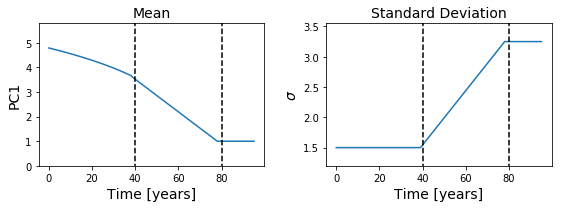

In [5]:
#define PC1 and sigma arrays through whole time period
PC1 = np.zeros_like(t) #initialize PC1 array
PC1[:N1] = 11.6 + 1.74*np.log(G[:N1]) #PC1 follows PC1 = PC1(G) up until the 1% glacierization time
PC1[N1-1:Ng-1] = np.linspace(PC1_g, PC1_f, Ng-N1) #then, between 1% glacierization and 0% glacierization, linear between PC1_g and PC1_f
PC1[Ng - 1:] = PC1_f #after glaciers lost, PC1 stays constant

sigma = np.zeros_like(t) #initialize sigma array
sigma[:N1] = np.linspace(sigma_0, sigma_g, N1) #sigma is constant before 1% glacierization time
sigma[N1-1:Ng-1] = np.linspace(sigma_g, sigma_f, Ng-N1) #linear transition to sigma_f
sigma[Ng-1:] = sigma_f #sigma remains constant after glaciers lost

#define dashed vertical lines to show t_1 and t_g on figures
dashx_g = t_g * np.ones(10)
dashy_g = np.linspace(-10,10,10)
dashx_1 = (t_1) * np.ones(10)
dashy_1 = np.linspace(-10,10,10)

#visualize linear transition
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,3))

axes[0].plot(t,PC1)
axes[0].plot(dashx_g, dashy_g, 'k--')
axes[0].plot(dashx_1, dashy_1, 'k--')
axes[0].set_xlabel('Time [years]', fontsize = fs)
axes[0].set_ylabel('PC1', fontsize = fs)
axes[0].set_title('Mean', fontsize = fs)
axes[0].set_ylim((np.min(PC1) - 1, np.max(PC1)+1))

axes[1].plot(t, sigma)
axes[1].plot(dashx_g, dashy_g, 'k--')
axes[1].plot(dashx_1, dashy_1, 'k--')
axes[1].set_xlabel('Time [years]', fontsize = fs)
axes[1].set_ylabel('$\sigma$', fontsize = fs)
axes[1].set_title('Standard Deviation', fontsize = fs)
axes[1].set_ylim((np.min(sigma) - 0.3, np.max(sigma)+0.3))

fig.tight_layout()

In [8]:
#visualize time progression with a Widget!

slider_time = ipywidgets.FloatSlider(value = 0, min=0, max = t_f, description = 'Time', continuous_update=False)

@ipywidgets.interact(tt = slider_time)#, eigvecs = eigvecs, PCs = PCs)

def plot_things(tt):

    if tt < t_g:
        GG = G_0 * (1 - tt/t_g)
    else:
        GG = 0

    if GG >= 0.01: #if glacier-forcing
        PP =  11.6 + 1.74*np.log(GG)
        ss = sigma_0
    elif (GG<0.1) & (GG>0): #if transitioning from glacier-to-climate

        PC1_1 = 11.6 + 1.74*np.log(0.01)
        m = (PC1_f - PC1_g)/(t_g - t_1)
        b = PC1_g - m*t_1
        PP = m*tt+b

        m = (sigma_f - sigma_g)/(t_g - t_1)
        b = sigma_g - m*t_1
        ss = m*tt+b

    else:
        PP = PC1_f
        ss = sigma_f

    dashx_g = t_g * np.ones(10)
    dashy_g = np.linspace(-10,10,10)
    dashx_1 = t_1 * np.ones(10)
    dashy_1 = np.linspace(-10,10,10)

    fig = plt.subplots(figsize = (16,6))

    ax = plt.subplot(2, 4, 1)
    ax.plot(t, G)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, GG, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w')
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('G [%]', fontsize = fs)
    ax.set_title('% Glacierization', fontsize = fs)
    ax.set_ylim((np.min(G) - 0.01, np.max(G)+0.01))

    ax = plt.subplot(2, 4, 2)
    ax.plot(PC1_climate, sigma_climate)
    ax.plot(PC1_glaciers, sigma_glaciers)
    ax.scatter(PP, ss, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w')
    ax.set_xlabel('PC1', fontsize = fs)
    ax.set_ylabel('$\sigma$', fontsize = fs)
    ax.set_title('Variability vs Mean', fontsize = fs)

    ax = plt.subplot(2, 4, 5)
    ax.plot(t,PC1)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, PP, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w', zorder = 3)
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('PC1', fontsize = fs)
    ax.set_title('Mean', fontsize = fs)
    ax.set_ylim((np.min(PC1) - 1, np.max(PC1)+1))

    ax = plt.subplot(2, 4, 6)
    ax.plot(t, sigma)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, ss, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w')
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('$\sigma$', fontsize = fs)
    ax.set_title('Standard Deviation', fontsize = fs)
    ax.set_ylim((np.min(sigma) - 0.3, np.max(sigma)+0.3))

    ax = plt.subplot(1, 2, 2)
    gauss_0, x_0 = make_gaussian(mu = PC1_0, sigma = sigma_0)
    gauss_f, x_f = make_gaussian(mu = PC1_f, sigma = sigma_f)
    gauss, x = make_gaussian(mu = PP, sigma = ss)
    ax.plot(x_0,gauss_0, 'k', label = '$t = 0$')
    ax.plot(x_f,gauss_f, 'k--', label = '$t = t_f$')
    ax.plot(x,gauss, label = '$t = $' + str(tt))
    ax.set_xlabel('Streamflow [unitless]', fontsize = fs)
    ax.set_ylabel('Probability', fontsize = fs)
    ax.set_title('Streamflow Probability', fontsize = fs)
    ax.legend(fontsize = fs)

    plt.tight_layout()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Time', max=96.0), Output())…

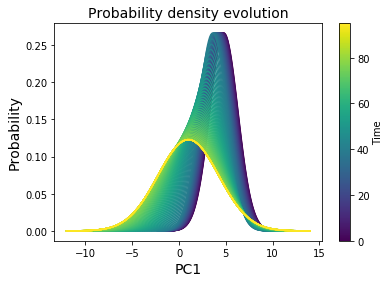

In [9]:
#visualize all streamflow probability densities in one figure

gausses = [] #empty list for all probabilities
xs = [] #empty list for all x-coordinates of probabilities
for t_step, PC1_step, sigma_step in zip(t, PC1, sigma):
    gauss, x = make_gaussian(mu = PC1_step, sigma = sigma_step)
    gausses.append(gauss)
    xs.append(x)
    
gausses = np.asarray(gausses)
xs = np.asarray(xs)

#define colourmap for time
cmap = 'viridis'
norm = colors.Normalize(vmin=min(t),vmax=max(t))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

cs = cm.get_cmap(cmap, Nf-1) #colours

fig, ax = plt.subplots()
for ii, tt in enumerate(t):
    ax.plot(xs[ii],gausses[ii], color = cs(ii))
ax.set_xlabel('PC1', fontsize = fs)
ax.set_ylabel('Probability', fontsize = fs)
ax.set_title('Probability density evolution', fontsize = fs)
cb = fig.colorbar(mappable, ax = ax)
cb.set_label('Time')

### Questions we can ask:

- Play around with $(PC_1, \sigma_{PC_1})_{initial}$ and $(PC_1, \sigma_{PC_1})_{final}$.  What does the transition look like under different initial and final conditions?
- Consider: what would make one transition scenario worse/better than another?  What do 'bad' transitions look like in terms of initial and final conditions?  Where, geographically, might this happen?
- If we lose 90% of glacier area, how will this river's streamflow change?  What about 70%?  
- What percent of glacier area can we afford to lose before the year-to-year variability begins to substantially increase?
- Under what conditions might streamflow rise (however briefly) under a loss of glaciers?  What happens if the variability increases substantially, but the mean decreases slowly?  What pair of $(PC_1, \sigma_{PC_1})_{initial}$ and $(PC_1, \sigma_{PC_1})_{final}$ could lead to this?  Check out the map of Alberta where this type of $(PC_1, \sigma_{PC_1})_{final}$ exists.  What climate is this?  Are there glaciated places on Earth with this type of climate?
- Based on these probabilities, generate a set of mean August streamflow timeseries.  What interesting features do you notice?

### Reference
Here is a [link to the paper](https://rdcu.be/b53pJ) which is used as a base for the discussion in the notebook.
  
Anderson, S., Radić, V. Identification of local water resource vulnerability to rapid deglaciation in Alberta.  *Nat. Clim. Chang.* **10**, 933 - 938 (2020).